In [1]:
### load modules 
import numpy as np
import pandas as pd
import glob
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import re 
import pickle
import pingouin as pg
from itertools import groupby
from operator import itemgetter
from patsy import dmatrices
import statsmodels.formula.api as smf
import statsmodels.discrete.discrete_model as sm
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm

### load my scripts 
import data_combiner as dc
import plotting_funcs as pf
import sim as sim


plt.rcParams["figure.figsize"] = (20,10)
sns.set_context('talk',font_scale=2)
plt.rcParams["lines.linewidth"] = 3

plt.rcParams['font.size'] = 15
plt.rcParams['font.family'] = 'Verdana'

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.3.10, the latest is 0.5.2.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


In [2]:
# load in data and clean it 
all_filenames = glob.glob("../../experiment/run_exp/data/*.csv")
all_data = dc.clean_data_group(all_filenames).reset_index(drop=True)
num_subs = len(list(set(all_data['sub_num'])))
all_data['prt_rel_om'] = all_data['prt'] - all_data['opt_prt_om'] # deviation from optimal 


In [4]:
# eliminate subs for the following reasons 

def who_to_drop(data):
    avgd_data = data.groupby(by=['sub_num']).mean().reset_index()
    mean = np.mean(avgd_data.prt)
    sd = stats.tstd(avgd_data.prt)
    
    # did not get both catch questions 
    subs_to_drop = list(set(all_data.query("catch_perf != 2 ").sub_num))
    
    # on average, only harvested 1 to 2 times per planet, inflexible decision strategy 
    criteria=avgd_data.prt < 1.5 
    ind=np.where(criteria==True)[0]
    subs_to_drop += avgd_data.iloc[ind,:].sub_num.to_list()
    
    # harvested more than the mean + 2 times the standard deviation 
    criteria=avgd_data.prt > mean + 2.0*sd
    ind=np.where(criteria==True)[0]
    subs_to_drop += avgd_data.iloc[ind,:].sub_num.to_list()
    
    # failed the practice quiz more than twice
    criteria= avgd_data.n_prac > 2
    ind=np.where(criteria==True)[0]
    subs_to_drop +=avgd_data.iloc[ind,:].sub_num.to_list()
    
    return subs_to_drop

# actually eliminate them here 
subs_to_drop = who_to_drop(all_data)
all_data = all_data[~all_data['sub_num'].isin(subs_to_drop)]

# overall overharvesting 

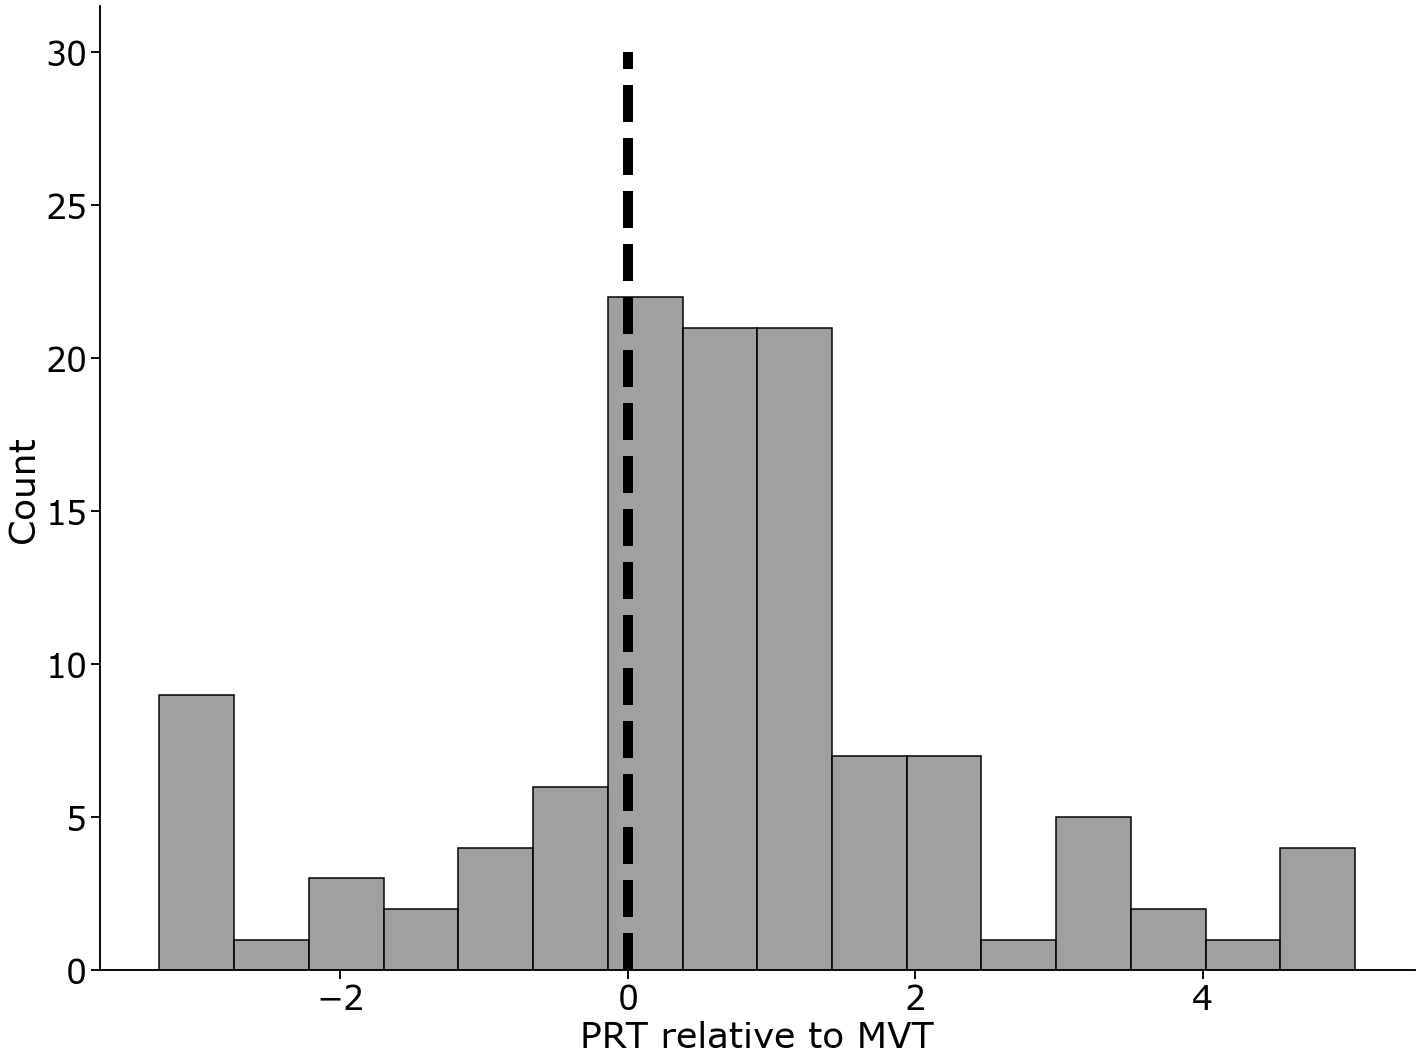

In [6]:
avgd_data = all_data.groupby(by=['sub_num']).mean().reset_index()
plt.rcParams["figure.figsize"] = (20,15)

sns.histplot(x='prt_rel_om',color='grey',data=avgd_data)
sns.despine(top=True,right=True)
plt.xlabel('PRT relative to MVT')
plt.plot([0,0],[0,30],'k--',linewidth=10)
plt.tight_layout()

plt.savefig('plots/avg_over_gal_indiv_sub.png')

In [7]:
avgd_data = all_data.groupby(by=['sub_num']).mean().reset_index()
stats.ttest_1samp(avgd_data.prt_rel_om,popmean=0)

Ttest_1sampResult(statistic=3.8750739257722056, pvalue=0.00017773074627967626)

# overharvesting with experience

In [8]:
def label_period(row):
    if row['block'] ==1:
        return 'early'
    elif row['block'] ==2:
        return 'early'
    elif row['block'] ==3:
        return 'med'
    elif row['block'] ==4:
        return 'late'
    elif row['block'] ==5:
        return 'late'

<ipython-input-9-03a78229895d>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_data['period'] = all_data.apply (lambda row: label_period(row), axis=1)


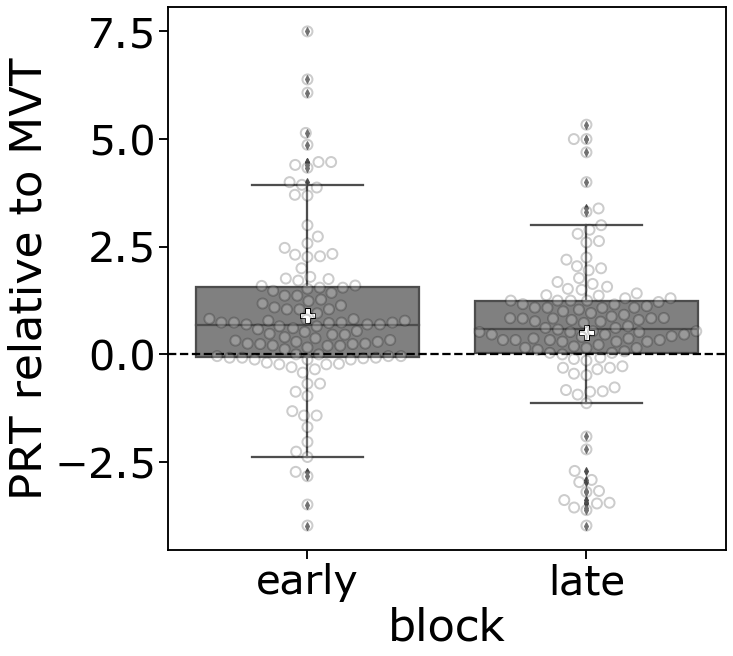

In [9]:
all_data['period'] = all_data.apply (lambda row: label_period(row), axis=1)
plt.rcParams["figure.figsize"] = (10,10)
sns.set_context('talk',font_scale=2.5)


avgd_data = all_data.groupby(by=['sub_num','period']).mean().reset_index()
#avgd_data=avgd_data.query("sub_num in @subs")
sns.swarmplot(x='period',y='prt_rel_om',color='white',edgecolor="black",linewidth=2,alpha=0.2,size=10,data=avgd_data.query(" period !='med'"))
sns.boxplot(x='period',y='prt_rel_om',color='grey',showmeans=True,
            meanprops={"marker":"P",
                       "markerfacecolor":"white", 
                       "markeredgecolor":"black",
                      "markersize":"15"},data=avgd_data.query(" period !='med'"))
plt.ylabel("PRT relative to MVT")
plt.xlabel("block")
plt.plot([-0.5,2.5],[0,0],'k--')

plt.savefig('plots/block_period.png',bbox_inches = "tight",dpi=300)

In [10]:
avgd_data = all_data.groupby(by=['sub_num','period']).mean().reset_index()

early=avgd_data.query("period=='early'").reset_index().prt_rel_om
late=avgd_data.query("period=='late'").reset_index().prt_rel_om

stats.ttest_rel(early,late)

Ttest_relResult(statistic=3.2726906650837297, pvalue=0.0014069975461516182)

# overharvesting per planet type

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 56.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 40.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 7.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


0
1
2


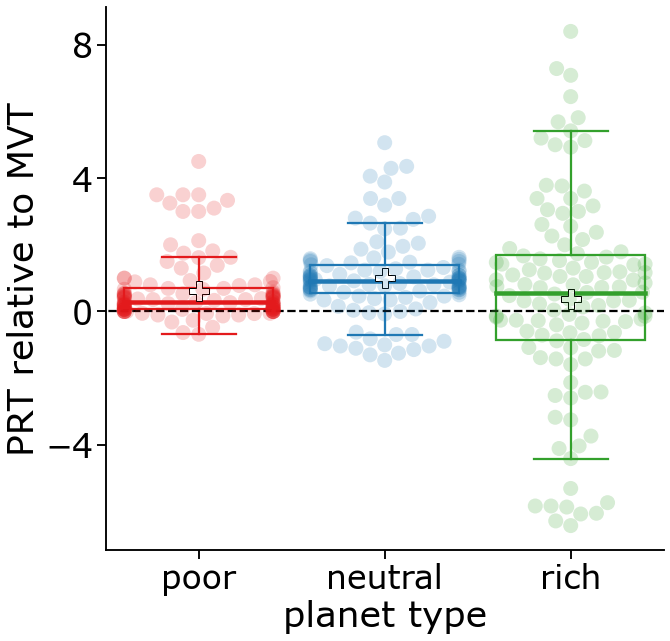

In [11]:
import matplotlib
plt.rcParams["figure.figsize"] = (10,10)
sns.set_context('talk',font_scale=2.0)

pal = sns.color_palette("Paired")
avgd_data = all_data.groupby(by=['sub_num','galaxy']).mean().reset_index()


# adjust these as per your data 
boxplot_width = .8 # thinner to make room for having swarmplot beside
swarmplot_offset = -0.0 # offset to left of boxplot
xlim_offset = -1 # necessary to show leftmost swarmplot  
rbg_pal = [pal[5],pal[1],pal[3]]
ax = sns.swarmplot(x='galaxy',y='prt_rel_om', palette=rbg_pal,alpha=0.2,size=15,data=avgd_data)

path_collections = [child for child in ax.get_children() 
                    if isinstance(child,matplotlib.collections.PathCollection)] 

for path_collection in path_collections: 
    x,y = np.array(path_collection.get_offsets()).T 
    xnew = x + swarmplot_offset
    offsets = list(zip(xnew,y)) 
    path_collection.set_offsets(offsets)

sns.boxplot(x='galaxy',y='prt_rel_om', showmeans=True,meanprops={"marker":"P",
                       "markerfacecolor":"white", 
                       "markeredgecolor":"black",
                      "markersize":"20"},showfliers = False,data=avgd_data, width=boxplot_width, ax=ax) 


for i,box in enumerate(ax.artists):
    box.set_edgecolor(rbg_pal[i])
    box.set_facecolor('white')
    print(i)
    # iterate over whiskers and median lines
    for j in range(6*i,len(ax.lines)):
         if (j==4) |(j==10) | (j==16):
             ax.lines[j].set_linewidth(4.5)
         ax.lines[j].set_color(rbg_pal[i])
            
def change_width(ax, new_value):
    for patch in ax.patches:
        current_width = patch.get_width()
        diff = current_width - new_value

        # change patch width
        patch.set_width(new_value)

        # re-center patch
        patch.set_x(patch.get_x() + diff * .5)

change_width(ax,.25)

ax.set_xticklabels(['poor','neutral','rich'], ha="center") # align labels to left
#ax.set_xlim(xlim_offset,ax.get_xlim()[1]) # to show leftmost swarmplot

plt.ylabel("PRT relative to MVT")
plt.xlabel("planet type")
plt.yticks([-8,-4,0,4,8])
plt.plot([-1,2.5],[0,0],'k--')
sns.despine(right=True)
plt.savefig('plots/overharvesting_galaxy.png',bbox_inches = "tight",dpi=300)

In [12]:
avgd_data = all_data.groupby(by=['sub_num','galaxy']).mean().reset_index()

print(stats.ttest_1samp(avgd_data.query('galaxy==0').prt_rel_om,popmean=0))
print(stats.ttest_1samp(avgd_data.query('galaxy==1').prt_rel_om,popmean=0))
print(stats.ttest_1samp(avgd_data.query('galaxy==2').prt_rel_om,popmean=0))

Ttest_1sampResult(statistic=6.923115011049861, pvalue=2.679084964561683e-10)
Ttest_1sampResult(statistic=9.00593130494536, pvalue=5.358558884154392e-15)
Ttest_1sampResult(statistic=1.3864788714050844, pvalue=0.16828278724279733)


# overhavesting under uncertainty

In [13]:
def label_switch(row):
    if row['num_in_gal'] ==1:
        return 'switch'
    else:
        return 'no_switch'
    
all_data['switch'] =  all_data.apply (lambda row: label_switch(row), axis=1)

<ipython-input-13-c92cb52784d7>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_data['switch'] =  all_data.apply (lambda row: label_switch(row), axis=1)


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 13.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


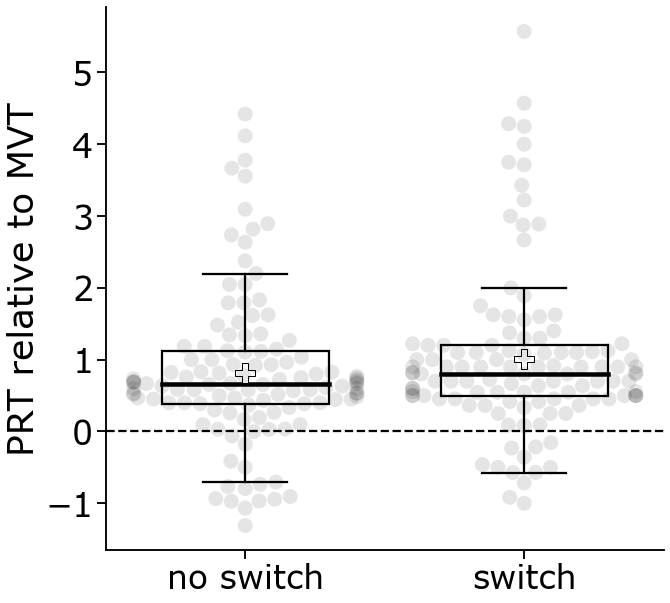

In [14]:
plt.rcParams["figure.figsize"] = (10,10)
sns.set_context('talk',font_scale=2.0)

avgd_data = all_data.query("galaxy!=2").groupby(by=['sub_num','switch']).mean().reset_index()

# adjust these as per your data 
boxplot_width = .6 # thinner to make room for having swarmplot beside
swarmplot_offset = -.0 # offset to left of boxplot
xlim_offset = -1 # necessary to show leftmost swarmplot  

ax = sns.swarmplot(x="switch", y="prt_rel_om", edgecolor='black',color='black',alpha=0.1,size=15,data=avgd_data)

path_collections = [child for child in ax.get_children() 
                    if isinstance(child,matplotlib.collections.PathCollection)] 

for path_collection in path_collections: 
    x,y = np.array(path_collection.get_offsets()).T 
    xnew = x + swarmplot_offset
    offsets = list(zip(xnew,y)) 
    path_collection.set_offsets(offsets)

sns.boxplot(x="switch", y="prt_rel_om", showmeans=True,meanprops={"marker":"P",
                       "markerfacecolor":"white", 
                       "markeredgecolor":"black",
                      "markersize":"20"},showfliers=False,data=avgd_data, width=boxplot_width, ax=ax) 


for i,box in enumerate(ax.artists):
    box.set_edgecolor('black')
    box.set_facecolor('white')

    # iterate over whiskers and median lines
    for j in range(6*i,len(ax.lines)):
         if (j==4) |(j==10):
             ax.lines[j].set_linewidth(4.5)
         ax.lines[j].set_color('black')
            
def change_width(ax, new_value):
    for patch in ax.patches:
        current_width = patch.get_width()
        diff = current_width - new_value

        # change patch width
        patch.set_width(new_value)

        # re-center patch
        patch.set_x(patch.get_x() + diff * .5)

change_width(ax,.25)

ax.set_xticklabels(ax.get_xticklabels(), ha="center") # align labels to left
#ax.set_xlim(xlim_offset,ax.get_xlim()[1]) # to show leftmost swarmplot

plt.xticks([0,1],['no switch','switch'])
plt.xlabel('')
#plt.xlim([-0.9,1.5])
plt.ylabel("PRT relative to MVT")
sns.despine(right=True)
plt.plot([-1.5,2.5],[0,0],'k--')

plt.savefig('plots/overharveting uncertainty.png',bbox_inches = "tight",dpi=300)

In [15]:
avgd_data = all_data.groupby(by=['sub_num','switch']).mean().reset_index()

switch=avgd_data.query("switch=='switch'").reset_index().prt_rel_om
no_switch=avgd_data.query("switch=='no_switch'").reset_index().prt_rel_om

stats.ttest_rel(switch,no_switch)


Ttest_relResult(statistic=1.862669315804744, pvalue=0.06506076141826392)

# Reaction Time check 

In [16]:
def make_sub_rt_df(sub_num):
    sub_df = pd.DataFrame(columns=['sub_num','condition','block','planet_num','stay_num','stay?','galaxy','prior_galaxy','num_in_gal'])
    curr_sub = all_data.query("sub_num=="+str(sub_num)).reset_index()
    n_planet = max(curr_sub.planet) + 1
    cond_num = curr_sub.condition[0]

    for p in range(n_planet):
        curr_planet = curr_sub.query("planet=="+str(p)).reset_index()
        curr_block = curr_planet.block[0]
        curr_galaxy = curr_planet.galaxy[0]
        curr_prior_galaxy = curr_planet.preced_gal[0]
        num_in_gal = curr_planet.num_in_gal[0]
        rt = curr_planet.rt_list[0]
        n_stay = len(rt)
        
        if n_stay == 0:
            rt = [np.nan]
            n_stay = 1
        tmp = pd.DataFrame({'sub_num':[sub_num]*n_stay, 'condition':[cond_num]*n_stay, 
                        'block':[curr_block]*n_stay,'planet_num':[p]*n_stay,'stay_num':range(n_stay),'stay?':[1]*(n_stay-1) + [0],
                        'galaxy':[curr_galaxy]*n_stay,'prior_galaxy':[curr_prior_galaxy]*n_stay,'num_in_gal':[num_in_gal]*n_stay,
                       'rt':rt})
        sub_df = pd.concat([sub_df,tmp])
    sub_df = sub_df.query("rt!=0")
    sub_df['zlog_rt'] = stats.zscore(np.log(sub_df['rt']),nan_policy='omit')
    return sub_df

def make_rt_df(subs):
    rt_df = pd.DataFrame(columns=['sub_num','condition','block','planet_num','stay_num','stay?','galaxy','prior_galaxy','num_in_gal'])

    for sub in subs:
        sub_df = make_sub_rt_df(sub)
        rt_df = pd.concat([rt_df,sub_df])
    return rt_df

In [17]:
subs = list(set(all_data.sub_num.tolist()))
rt_df = make_rt_df(subs)
rt_df['switch'] = rt_df.apply (lambda row: label_switch(row), axis=1)


<ipython-input-16-27702c2ea87b>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_df['zlog_rt'] = stats.zscore(np.log(sub_df['rt']),nan_policy='omit')
<ipython-input-16-27702c2ea87b>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_df['zlog_rt'] = stats.zscore(np.log(sub_df['rt']),nan_policy='omit')
<ipython-input-16-27702c2ea87b>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats i

# reaction time in response to uncertainty

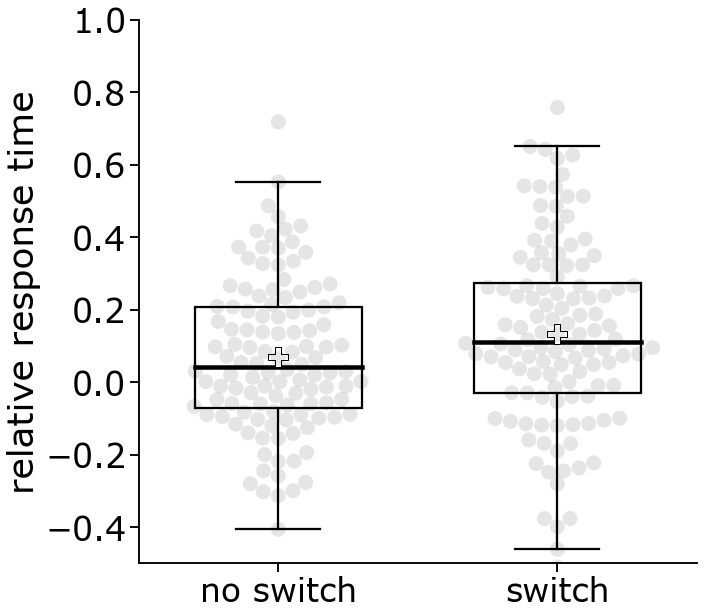

In [18]:
plt.rcParams["figure.figsize"] = (10,10)
sns.set_context('talk',font_scale=2.0)
pal=sns.color_palette("Paired")

avg_switch=rt_df.query("stay_num==1").groupby(by=['sub_num','switch']).mean().reset_index()

# adjust these as per your data 
boxplot_width = .6 # thinner to make room for having swarmplot beside
swarmplot_offset = -.0 # offset to left of boxplot
xlim_offset = -1 # necessary to show leftmost swarmplot  

ax = sns.swarmplot(x="switch", y="zlog_rt", edgecolor='black',color='black',alpha=0.1,size=15,data=avg_switch)

path_collections = [child for child in ax.get_children() 
                    if isinstance(child,matplotlib.collections.PathCollection)] 

for path_collection in path_collections: 
    x,y = np.array(path_collection.get_offsets()).T 
    xnew = x + swarmplot_offset
    offsets = list(zip(xnew,y)) 
    path_collection.set_offsets(offsets)

sns.boxplot(x="switch", y="zlog_rt", showmeans=True,meanprops={"marker":"P",
                       "markerfacecolor":"white", 
                       "markeredgecolor":"black",
                      "markersize":"20"},showfliers=False,data=avg_switch, width=boxplot_width, ax=ax) 


for i,box in enumerate(ax.artists):
    box.set_edgecolor('black')
    box.set_facecolor('white')

    # iterate over whiskers and median lines
    for j in range(6*i,len(ax.lines)):
         if (j==4) |(j==10):
             ax.lines[j].set_linewidth(4.5)
         ax.lines[j].set_color('black')
            
def change_width(ax, new_value):
    for patch in ax.patches:
        current_width = patch.get_width()
        diff = current_width - new_value

        # change patch width
        patch.set_width(new_value)

        # re-center patch
        patch.set_x(patch.get_x() + diff * .5)

change_width(ax,.25)

ax.set_xticklabels(ax.get_xticklabels(), ha="center") # align labels to left
#ax.set_xlim(xlim_offset,ax.get_xlim()[1]) # to show leftmost swarmplot

plt.xticks([0,1],['no switch','switch'])
plt.xlabel('')
#plt.xlim([-0.9,1.5])
plt.ylim([-0.5,1.0])
plt.ylabel('relative response time')
sns.despine(right=True)
plt.savefig("plots/switch_zlog_rt.png",bbox_inches = "tight",dpi=300)

In [19]:
avg_switch=rt_df.query("stay_num==1").groupby(by=['sub_num','switch']).mean().reset_index()
switch=avg_switch.query("switch=='switch'").zlog_rt.reset_index(drop=True)
no_switch=avg_switch.query("switch=='no_switch'").zlog_rt.reset_index(drop=True)
stats.ttest_rel(switch,no_switch)

Ttest_relResult(statistic=2.645000360675243, pvalue=0.009311089367316103)

# parameter validation

In [22]:
# Load fit parameters
params = pd.read_csv("../model/fitting/params_val_adaptive_discount_10_10_3.csv")

# join with choice & reaction time behavior 
params=params.join(avg_switch.set_index('sub_num'), on='sub_num').dropna()

# transform to be normally distributed 
params['alphaz']=-np.log(-1 + (10/np.array(params['alpha'])))
params['gamma_basez']=-np.log(-1 + ((12)/(np.array(params['gamma_base']+2))));
params['gamma_coefz']=-np.log(-1 + (6/(np.array(params['gamma_coef']+3))));

avg_explicit_switch=all_data.groupby(by=['sub_num','switch']).mean().prt_rel_om.reset_index()

no_switch=avg_explicit_switch.query("switch=='no_switch'").prt_rel_om.reset_index(drop=True)
switch=avg_explicit_switch.query("switch=='switch'").prt_rel_om.reset_index(drop=True)
diff=switch-no_switch
params['switch_explicit']= diff

FileNotFoundError: [Errno 2] No such file or directory: '../model/fitting/experiment1k_rescorla_wagner/params_val_adaptive_discount_10_10_3.csv'

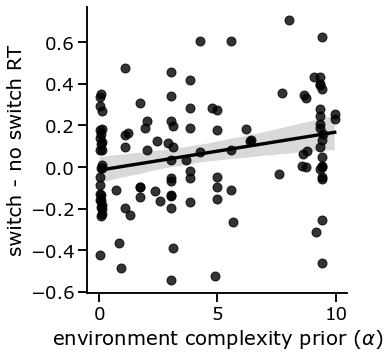

In [72]:
sns.set_context('talk',font_scale=1.1)

sns.lmplot(x='alpha',y='zlog_rt',scatter_kws={'color':'k'},line_kws={'color':'k'},data=params)
plt.xlabel(r'environment complexity prior ($\alpha$)')
plt.ylabel("switch - no switch RT")
plt.xlim([-0.5,10.5])
plt.savefig("plots/alpha_zlog_rt_corr.png",bbox_inches = "tight",dpi=300)

In [ ]:
pg.corr(params['alphaz'],params['zlog_rt'],method='kendall')

In [251]:
pg.corr(params['alphaz'],params['gamma_coefz'],method='kendall')

,n,r,CI95%,r2,adj_r2,p-val,power
kendall,116,-0.331375,"[-0.48, -0.16]",0.109809,0.094054,2.944709e-07,0.956818


In [215]:
%%R params

params$alpha2 <- params$alphaz^2


#fit quadratic regression model
quadraticModel <- lm(gamma_coefz ~ alpha + alpha2, data=params)

#view model summary
summary(quadraticModel)


Call:
lm(formula = gamma_coefz ~ alpha + alpha2, data = params)

Residuals:
    Min      1Q  Median      3Q     Max 
-1.2270 -0.1609 -0.1166  0.0312  2.4156 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  0.28178    0.10039   2.807  0.00589 ** 
alpha       -0.02653    0.01475  -1.799  0.07465 .  
alpha2       0.02092    0.00489   4.279 3.96e-05 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.5147 on 113 degrees of freedom
Multiple R-squared:  0.2266,	Adjusted R-squared:  0.2129 
F-statistic: 16.55 on 2 and 113 DF,  p-value: 4.957e-07



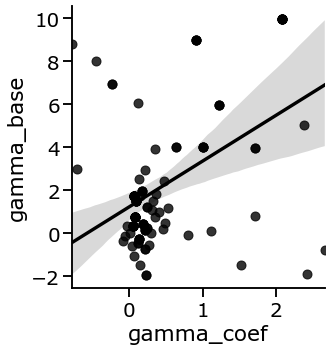

In [218]:
sns.lmplot(x='gamma_coef',y='gamma_base',order=1,scatter_kws={'color':'k'},line_kws={'color':'k'},data=params)


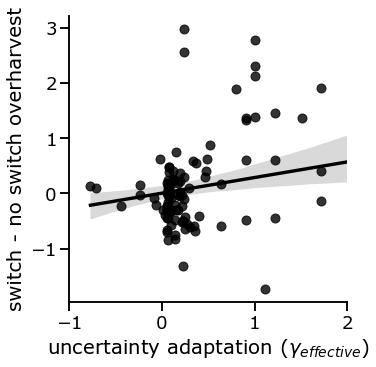

In [73]:
sns.set_context('talk',font_scale=1.1)

sns.lmplot(x='gamma_coef',y='switch_explicit',scatter_kws={'color':'k'},line_kws={'color':'k'},data=params)
plt.xlabel(r'uncertainty adaptation ($\gamma_{effective}$)')
plt.ylabel("switch - no switch overharvest")
plt.xlim([-1,2])
#plt.ylim([-0.5,0.5])
plt.savefig("plots/gamma_coef_overharvesting_corr.png",bbox_inches = "tight",dpi=300)

In [ ]:
pg.corr(params['gamma_coefz'],params['switch_explicit'],method='kendall')

In [51]:
pg.corr(params['alphaz'],params['zlog_rt'],method='kendall')

,n,r,CI95%,r2,adj_r2,p-val,power
kendall,76,0.233599,"[0.01, 0.44]",0.054568,0.028666,0.003535,0.533885
